<a href="https://colab.research.google.com/github/punnoose-1620/masters-thesis-sensor-data/blob/agentic-model/CSV_Builder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs and Imports

### Installs

In [16]:
!pip install csv matplotlib collections

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement csv (from versions: none)

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for csv


### Imports

In [17]:
import io
import os
import csv
from collections import Counter
import matplotlib.pyplot as plt

## Constants

### INPUT — paste your full text block here between the triple quotes

In [ ]:
RAW_TEXT = """
"""

### CONFIG

In [2]:
OUTPUT_FILE = "llm-tester.csv"

## Essential Functions

### PARSER

In [5]:
def parse_text_to_rows(text: str) -> tuple[list[str], list[list[str]]]:
    """
    Parse a quoted-CSV formatted string into a header row and data rows.
    Handles commas inside quoted fields correctly via Python's csv module.
    Skips blank lines automatically.
    """
    lines = [line.strip() for line in text.strip().splitlines() if line.strip()]

    if not lines:
        raise ValueError("Input text is empty — nothing to parse.")

    reader = csv.reader(io.StringIO("\n".join(lines)))
    rows = list(reader)

    if not rows:
        raise ValueError("No rows found after parsing.")

    header = rows[0]
    data   = rows[1:]

    return header, data

### WRITER

In [6]:
def write_to_csv(header: list[str], data: list[list[str]], filepath: str) -> None:
    """
    Write data rows to CSV.
    - If the file does NOT exist  → create it and write header + data.
    - If the file DOES exist      → append data rows only (no duplicate header).
    """
    file_exists = os.path.isfile(filepath)

    if file_exists:
        print(f"[INFO] '{filepath}' found — appending {len(data)} row(s).")
        mode = "a"
    else:
        print(f"[INFO] '{filepath}' not found — creating new file.")
        mode = "w"

    with open(filepath, mode=mode, newline="", encoding="utf-8") as f:
        writer = csv.writer(f, quoting=csv.QUOTE_ALL)

        if not file_exists:
            writer.writerow(header)   # Write header only for new files

        writer.writerows(data)

    action = "Appended" if file_exists else "Created"
    print(f"[OK]   {action} '{filepath}' — total rows added: {len(data)}")

## Main Creation Pipeline

In [11]:
print("=" * 55)
print("  text → llm-test-data.csv converter")
print("=" * 55)

try:
    header, data = parse_text_to_rows(RAW_TEXT)

    print(f"[INFO] Columns  : {header}")
    print(f"[INFO] Rows parsed: {len(data)}")

    if not data:
        print("[WARN] No data rows found — check your RAW_TEXT input.")
    else:
        write_to_csv(header, data, OUTPUT_FILE)

except Exception as e:
    print(f"[ERROR] {e}")
    raise

  text → llm-test-data.csv converter
[INFO] Columns  : ['source', 'category', 'question', 'points to be included in answer', 'source of answer (file name/url) SharePoint', 'technical', 'How do I connect the tablet to the WICE unit and open the WICE checklist?', 'Plug tablet into ETH1; power on and swipe up; log in as Workshop/1234; open Chrome or press P1; press P2 to refresh; if page doesn’t load tap WICE Install or Home', 'WICE Tablet Instruction_v3_2025w07.pdf - \u200bhttps://intranet.volvocars.net/sites/WICEDevelopment/Shared%20Documents/WICE%20Installation%20Manuals/Tablet%20Instruction/WICE%20Tablet%20Instruction_v3_2025w07.pdf\u200b SharePoint', 'technical', 'What should I do if the Start switch shows INT Red on the checklist?', 'Flip physical Start switch from INT to EXT on the back of the WICE unit; checklist should show Start switch EXT Green', 'WICE Tablet Instruction_v3_2025w07.pdf - \u200bhttps://intranet.volvocars.net/sites/WICEDevelopment/Shared%20Documents/WICE%20Instal

## Visualization

### Load Data from File

In [4]:
def read_llm_tester_csv():
    """Read all data from llm-tester.csv; returns (headers, rows)."""
    with open(OUTPUT_FILE, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        headers = next(reader)
        rows = list(reader)
    return headers, rows

### Data Source Distribution

In [24]:
def get_source(row, col_idx, SOURCE_COL):
    if isinstance(row, dict):
        val = row.get(SOURCE_COL) or ''
    elif isinstance(row, (list, tuple)) and len(row) > col_idx:
        val = row[col_idx]
    else:
        val = ''
    if not isinstance(val, str):
        val = str(val) if val is not None else ''
    return val.strip() or '(empty)'

In [27]:
def visualize_source_distribution(data):
    """
    Visualize the distribution of entries by the 'source' column.
    data: either (headers, rows) from read_llm_tester_csv(), or a list of data rows only.
    """
    SOURCE_COL = 'source'

    # Unpack (headers, rows) if needed
    if isinstance(data, (list, tuple)) and len(data) == 2:
        headers, rows = data[0], data[1]
        if isinstance(rows, list) and rows and isinstance(rows[0], (list, tuple)):
            data = rows
        else:
            data = rows if isinstance(rows, list) else data
    else:
        headers = None

    # Column index for source (first column = 0)
    if headers and isinstance(headers, (list, tuple)):
        try:
            col_idx = headers.index(SOURCE_COL)
        except ValueError:
            col_idx = 0
    else:
        col_idx = 0

    from collections import Counter
    sources = [get_source(row, col_idx, SOURCE_COL) for row in data]
    counts = Counter(sources)
    sorted_items = sorted(counts.items(), key=lambda x: -x[1])
    labels = [k for k, _ in sorted_items]
    vals = [v for _, v in sorted_items]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    colors = plt.cm.Set3(range(len(labels)))  # different color per source

    # Bar chart
    bars = ax1.bar(labels, vals, color=colors, edgecolor='black', alpha=0.8)
    ax1.set_ylabel('Number of entries')
    ax1.set_xlabel('Source')
    ax1.set_title('Entries by source')
    ax1.tick_params(axis='x', labelrotation=45)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    for bar, val in zip(bars, vals):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(), str(val),
                 ha='center', va='bottom', fontweight='bold')

    # Pie chart
    ax2.pie(vals, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax2.set_title('Share by source')

    plt.tight_layout()
    plt.show()

### Technical vs Non-technical

In [14]:
def get_category(row):
    if isinstance(row, dict):
        val = row.get('category') or ''
    elif isinstance(row, (list, tuple)) and len(row) > 1:
        val = row[1]
    else:
        val = ''
    if not isinstance(val, str):
        val = str(val) if val is not None else ''
    return val.strip().lower()

In [15]:
def visualize_technical_vs_nontechnical(data):
    """
    Count technical vs non-technical questions by category, and show a bar chart and pie chart.
    data: either (headers, rows) from read_llm_tester_csv(), or a list of data rows only.
    """
    # If data is (headers, rows) from read_llm_tester_csv(), use only the data rows
    if isinstance(data, (list, tuple)) and len(data) == 2:
        headers, rows = data[0], data[1]
        if isinstance(rows, list) and rows and isinstance(rows[0], (list, tuple)):
            data = rows  # data is now list of row lists
        # else: data stays as-is (e.g. single list of rows)

    technical = sum(1 for row in data if get_category(row) == 'technical')
    non_technical = sum(1 for row in data if get_category(row) == 'non-technical')
    other = len(data) - technical - non_technical

    labels = ['Technical', 'Non-technical']
    counts = [technical, non_technical]
    if other > 0:
        labels.append('Other')
        counts.append(other)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    colors = ['#2ecc71', '#3498db', '#95a5a6']

    bars = ax1.bar(labels, counts, color=colors[:len(labels)])
    ax1.set_ylabel('Number of questions')
    ax1.set_title('Technical vs non-technical questions')
    for bar, val in zip(bars, counts):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(), str(val),
                 ha='center', va='bottom', fontweight='bold')

    ax2.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors[:len(labels)], startangle=90)
    ax2.set_title('Distribution by type')

    plt.tight_layout()
    plt.show()

### Inclusion Points Count Distribution

In [18]:
def get_points_cell(row, col_idx, POINTS_COL):
    if isinstance(row, dict):
        val = row.get(POINTS_COL) or ''
    elif isinstance(row, (list, tuple)) and len(row) > col_idx:
        val = row[col_idx]
    else:
        val = ''
    if not isinstance(val, str):
        val = str(val) if val is not None else ''
    return val

In [19]:
def visualize_points_count_distribution(data):
    """
    Visualize the distribution of the count of semicolon-separated items
    in the 'points to be included in answer' column.
    data: either (headers, rows) from read_llm_tester_csv(), or a list of data rows only.
    """
    POINTS_COL = 'points to be included in answer'

    # Unpack (headers, rows) if needed
    if isinstance(data, (list, tuple)) and len(data) == 2:
        headers, rows = data[0], data[1]
        if isinstance(rows, list) and rows and isinstance(rows[0], (list, tuple)):
            data = rows
        else:
            data = rows if isinstance(rows, list) else data
    else:
        headers = None

    # Resolve column index for "points to be included in answer"
    if headers and isinstance(headers, (list, tuple)):
        try:
            col_idx = headers.index(POINTS_COL)
        except ValueError:
            col_idx = 3  # fallback: 4th column
    else:
        col_idx = 3    

    # Count how many semicolon-separated items per row
    counts = []
    for row in data:
        cell = get_points_cell(row, col_idx, POINTS_COL)
        parts = [p.strip() for p in cell.split(';') if p.strip()]
        counts.append(len(parts) if parts else 0)

    # Build distribution: how many rows have 1 point, 2 points, etc.
    dist = Counter(counts)
    # Sort by number of points (x-axis)
    sorted_items = sorted(dist.items())
    x_vals = [k for k, _ in sorted_items]
    y_vals = [v for _, v in sorted_items]

    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(x_vals, y_vals, color='#3498db', edgecolor='black', alpha=0.8)
    ax.set_xlabel('Number of points (semicolon-separated items)')
    ax.set_ylabel('Number of rows')
    ax.set_title("Distribution of 'points to be included in answer' count per row")
    for bar, val in zip(bars, y_vals):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(), str(val),
                ha='center', va='bottom', fontweight='bold')
    plt.tight_layout()
    plt.show()

### Source File Distribution

In [21]:
def get_source_cell(row, col_idx, SOURCE_COL):
        if isinstance(row, dict):
            val = row.get(SOURCE_COL) or ''
        elif isinstance(row, (list, tuple)) and len(row) > col_idx:
            val = row[col_idx]
        else:
            val = ''
        if not isinstance(val, str):
            val = str(val) if val is not None else ''
        return val

In [22]:
def visualize_source_of_answer_filename_count(data):
    """
    Visualize the count of file names from the 'source of answer (file name/url)' column.
    Column format: "file name - url". Extracts the part before " - " as file name.
    data: either (headers, rows) from read_llm_tester_csv(), or a list of data rows only.
    """
    SOURCE_COL = 'source of answer (file name/url)'
    SEP = ' - '  # file name - url

    # Unpack (headers, rows) if needed
    if isinstance(data, (list, tuple)) and len(data) == 2:
        headers, rows = data[0], data[1]
        if isinstance(rows, list) and rows and isinstance(rows[0], (list, tuple)):
            data = rows
        else:
            data = rows if isinstance(rows, list) else data
    else:
        headers = None

    # Column index for source of answer
    if headers and isinstance(headers, (list, tuple)):
        try:
            col_idx = headers.index(SOURCE_COL)
        except ValueError:
            col_idx = 4  # 5th column
    else:
        col_idx = 4

    # Extract file name (part before " - ") and count
    file_names = []
    for row in data:
        cell = get_source_cell(row, col_idx, SOURCE_COL)
        if SEP in cell:
            name = cell.split(SEP, 1)[0].strip()
        else:
            name = cell.strip() or '(empty)'
        file_names.append(name)

    counts = Counter(file_names)
    # Sort by count descending for the chart
    sorted_items = sorted(counts.items(), key=lambda x: -x[1])
    names = [n for n, _ in sorted_items]
    vals = [v for _, v in sorted_items]

    fig, ax = plt.subplots(figsize=(10, max(6, len(names) * 0.35)))
    y_pos = range(len(names))
    bars = ax.barh(y_pos, vals, color='#3498db', edgecolor='black', alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names, fontsize=9)
    ax.set_xlabel('Number of rows')
    ax.set_ylabel('File name')
    ax.set_title("Count of rows by source of answer (file name)")
    ax.invert_yaxis()  # top count at top
    for bar, val in zip(bars, vals):
        ax.text(val, bar.get_y() + bar.get_height()/2., f' {val}', va='center', fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.show()

### Word Count Distribution

In [29]:
def get_question(row, col_idx, QUESTION_COL):
        if isinstance(row, dict):
            val = row.get(QUESTION_COL) or ''
        elif isinstance(row, (list, tuple)) and len(row) > col_idx:
            val = row[col_idx]
        else:
            val = ''
        if not isinstance(val, str):
            val = str(val) if val is not None else ''
        return val

In [30]:
def get_questions_from_data(data):
    """
    Normalize data (headers, rows) or list of rows and return a list of question strings
    from the 'question' column. Use this for any visualization that needs question text.
    """
    QUESTION_COL = 'question'

    if isinstance(data, (list, tuple)) and len(data) == 2:
        headers, rows = data[0], data[1]
        if isinstance(rows, list) and rows and isinstance(rows[0], (list, tuple)):
            data = rows
        else:
            data = rows if isinstance(rows, list) else data
    else:
        headers = None

    if headers and isinstance(headers, (list, tuple)):
        try:
            col_idx = headers.index(QUESTION_COL)
        except ValueError:
            col_idx = 2
    else:
        col_idx = 2

    return [get_question(row, col_idx, QUESTION_COL) for row in data]

In [31]:
def visualize_question_word_count(data):
    """
    Visualize the distribution of word counts for entries in the 'question' column.
    """
    questions = get_questions_from_data(data)
    word_counts = [len(q.split()) for q in questions]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(word_counts, bins=range(0, max(word_counts) + 2) if word_counts else [0],
            edgecolor='black', alpha=0.8, color='#2ecc71')
    ax.set_xlabel('Word count')
    ax.set_ylabel('Number of questions')
    ax.set_title("Distribution of word count per question")
    plt.tight_layout()
    plt.show()

### Character Count Distribution

In [32]:
def visualize_question_char_count(data):
    """
    Visualize the distribution of character counts for entries in the 'question' column.
    """
    questions = get_questions_from_data(data)
    char_counts = [len(q) for q in questions]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(char_counts, bins=min(30, max(1, len(set(char_counts)))),
            edgecolor='black', alpha=0.8, color='#3498db')
    ax.set_xlabel('Character count')
    ax.set_ylabel('Number of questions')
    ax.set_title("Distribution of character count per question")
    plt.tight_layout()
    plt.show()

## Main Visualization Pipeline

In [6]:
data = read_llm_tester_csv()
print(f"Loaded {len(data)} rows.")
print(data[0])  # first row as dict

Loaded 2 rows.
['source', 'category', 'question', 'points to be included in answer', 'source of answer (file name/url)']


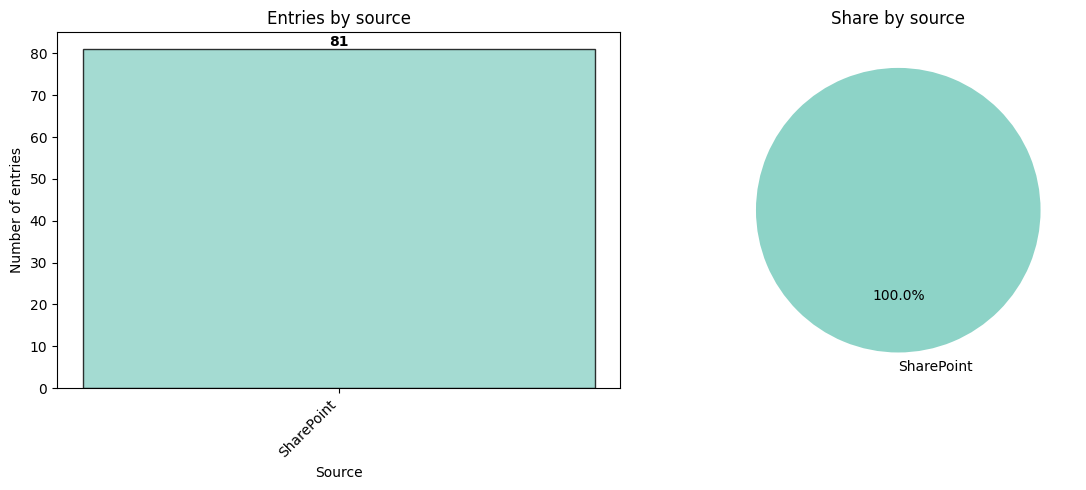

In [28]:
visualize_source_distribution(data)

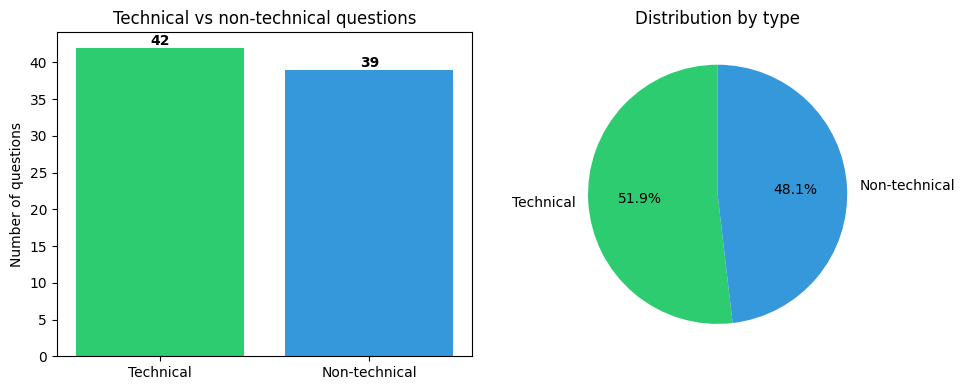

In [13]:
visualize_technical_vs_nontechnical(data)

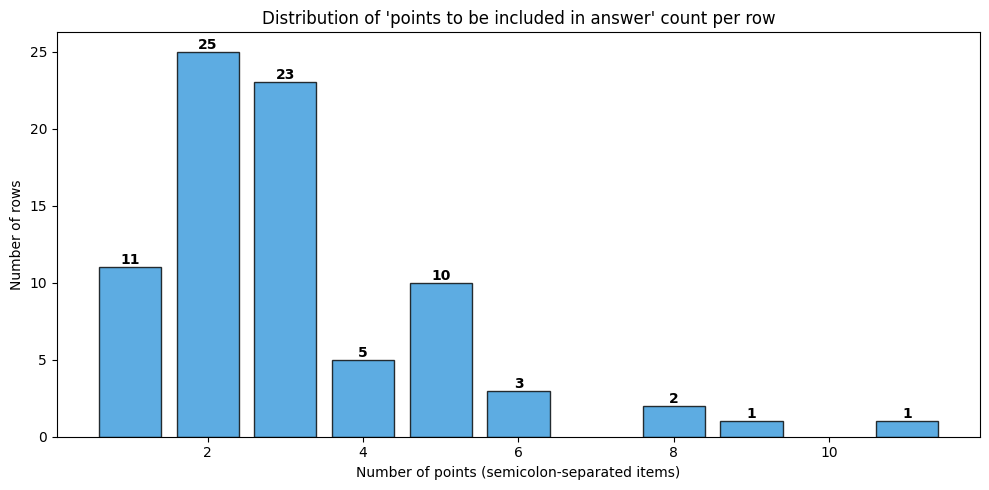

In [20]:
visualize_points_count_distribution(data)

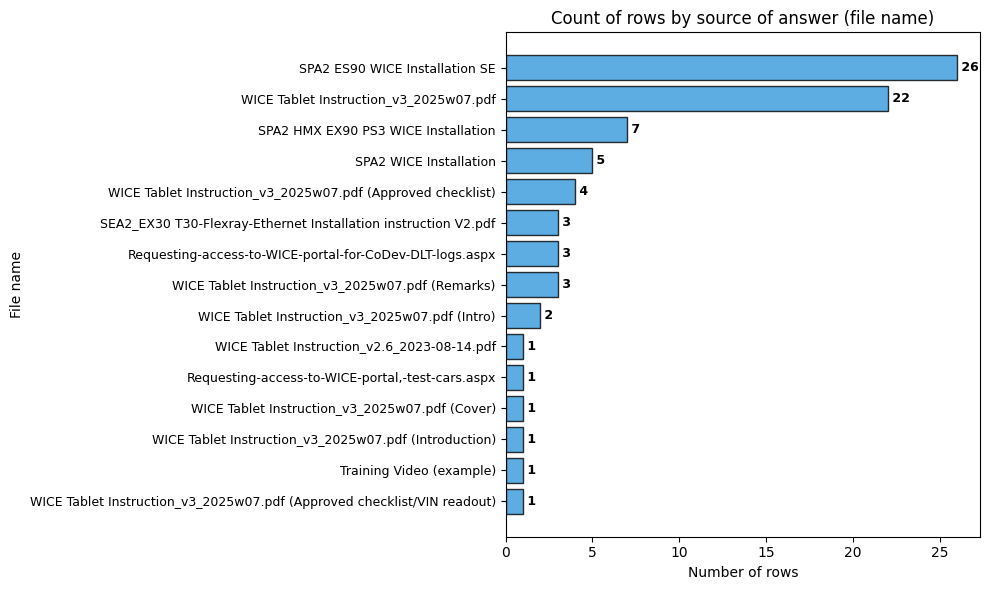

In [23]:
visualize_source_of_answer_filename_count(data)

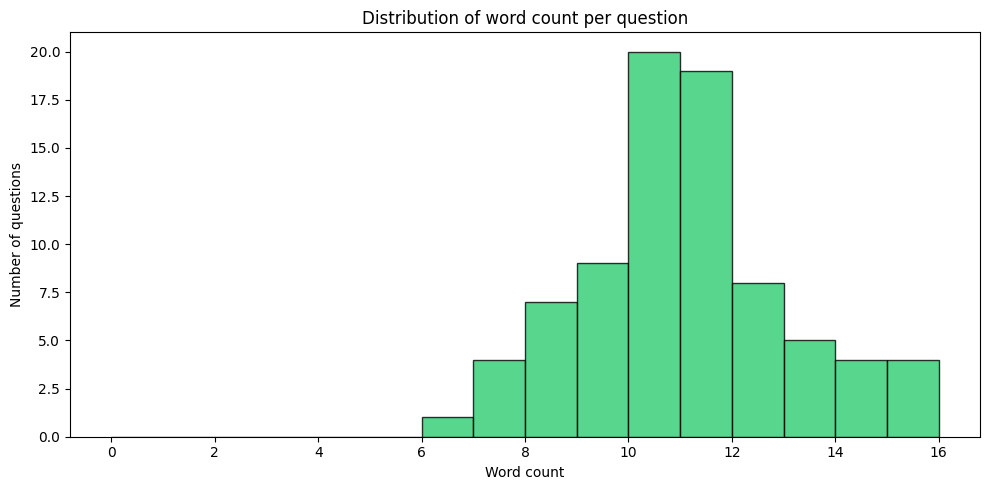

In [33]:
visualize_question_word_count(data)

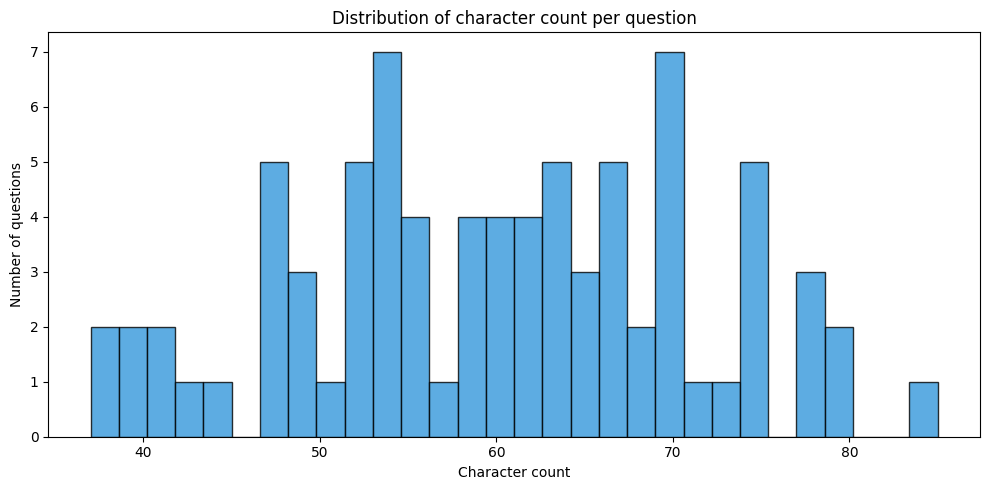

In [34]:
visualize_question_char_count(data)